# Weather Data - Exploratory Data Analysis

**Objective:** Comprehensive analysis of Open-Meteo weather data from S3 Bronze layer to understand:
- Weather patterns and distributions across Chicago & Evanston
- Seasonal and temporal variations
- Weather impact on bike-share usage patterns
- Data quality and completeness assessment

**Data Source:** S3 Bronze Layer - `s3://divvybikes-dev-bronze-96wb3c9c/weather-data/`

**Analysis Period:** Q1 2023 & Q1 2024 Historical Weather Data for Chicago & Evanston

**Technical Note:** This notebook uses **Python-only** for reliable, kernel-safe analysis. R integration removed due to memory issues.

In [8]:
# Setup Python Environment (Pure Python - No R)
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import boto3
from io import StringIO
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("viridis")

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("✅ Python environment setup complete!")
print("🌤️ Pure Python approach - no R dependencies")
print("📊 Ready for kernel-safe weather data analysis")

# Test basic functionality
print(f"\n🧪 Environment test:")
print(f"✅ pandas version: {pd.__version__}")
print(f"✅ numpy version: {np.__version__}")
print(f"✅ matplotlib available")
print(f"✅ seaborn available")
print(f"✅ boto3 available for S3 access")
print(f"✅ plotly available for interactive visualizations")

✅ Python environment setup complete!
🌤️ Pure Python approach - no R dependencies
📊 Ready for kernel-safe weather data analysis

🧪 Environment test:
✅ pandas version: 2.3.1
✅ numpy version: 2.3.1
✅ matplotlib available
✅ seaborn available
✅ boto3 available for S3 access
✅ plotly available for interactive visualizations


In [9]:
# Configure AWS S3 Connection for Weather Data (Python-only)
import boto3
from botocore.exceptions import ClientError

print("🔧 Setting up AWS S3 connection for weather data...")

# AWS S3 Configuration - Updated based on terraform configuration
AWS_REGION = 'ap-southeast-2'
BUCKET_NAME = 'divvybikes-dev-bronze-96wb3c9c'  # From the working divvy trips notebook
S3_WEATHER_PREFIX = 'weather-data/'

def list_s3_weather_files():
    """List all weather CSV files in S3 Bronze layer"""
    try:
        # Initialize S3 client
        s3_client = boto3.client('s3', region_name=AWS_REGION)
        
        print(f"📡 Connecting to S3 bucket: {BUCKET_NAME}")
        print(f"🌏 Region: {AWS_REGION}")
        print(f"📁 Weather prefix: {S3_WEATHER_PREFIX}")
        
        # List objects with weather-data prefix
        response = s3_client.list_objects_v2(
            Bucket=BUCKET_NAME,
            Prefix=S3_WEATHER_PREFIX,
            MaxKeys=100
        )
        
        if 'Contents' in response:
            weather_files = []
            for obj in response['Contents']:
                key = obj['Key']
                if key.endswith('.csv'):
                    weather_files.append({
                        'Key': key,
                        'Size': obj['Size'],
                        'LastModified': obj['LastModified']
                    })
            
            print(f"✅ S3 connection successful!")
            print(f"📄 Found {len(weather_files)} weather CSV files")
            
            # Check for different locations
            locations = {'chicago': 0, 'evanston': 0, 'other': 0}
            for file in weather_files:
                key_lower = file['Key'].lower()
                if 'chicago' in key_lower:
                    locations['chicago'] += 1
                elif 'evanston' in key_lower:
                    locations['evanston'] += 1
                else:
                    locations['other'] += 1
            
            print(f"\n📍 Weather data by location:")
            for location, count in locations.items():
                if count > 0:
                    print(f"   • {location.title()}: {count} files")
            
            # Show sample files
            print(f"\n📋 Sample weather files:")
            for file in weather_files[:5]:
                print(f"   • {file['Key']} ({file['Size']} bytes)")
            
            return weather_files
        else:
            print("⚠️ No files found in weather-data prefix")
            return []
            
    except ClientError as e:
        print(f"❌ S3 connection failed: {e}")
        return []
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return []

# List available weather files
weather_s3_files = list_s3_weather_files()

if weather_s3_files:
    print(f"\n🎉 Weather data discovery complete!")
else:
    print(f"\n📝 Weather data discovery failed. Check:")
    print(f"   1. AWS credentials are configured")
    print(f"   2. Bucket {BUCKET_NAME} exists and is accessible")
    print(f"   3. Weather data exists in {S3_WEATHER_PREFIX} prefix")

🔧 Setting up AWS S3 connection for weather data...
📡 Connecting to S3 bucket: divvybikes-dev-bronze-96wb3c9c
🌏 Region: ap-southeast-2
📁 Weather prefix: weather-data/
✅ S3 connection successful!
📄 Found 48 weather CSV files

📍 Weather data by location:
   • Chicago: 24 files
   • Evanston: 24 files

📋 Sample weather files:
   • weather-data/location=chicago/year=2023/month=01/weather_data_chicago_2023_01.csv (6739 bytes)
   • weather-data/location=chicago/year=2023/month=02/weather_data_chicago_2023_02.csv (6265 bytes)
   • weather-data/location=chicago/year=2023/month=03/weather_data_chicago_2023_03.csv (6830 bytes)
   • weather-data/location=chicago/year=2023/month=04/weather_data_chicago_2023_04.csv (6670 bytes)
   • weather-data/location=chicago/year=2023/month=05/weather_data_chicago_2023_05.csv (6895 bytes)

🎉 Weather data discovery complete!


In [10]:
# Load Weather Data from S3 (Q1 2023 & Q1 2024 only)
# Pure Python implementation for kernel-safe loading

def load_weather_data_q1(years=["2023", "2024"], max_files=None, sample_frac=1.0):
    """
    Load weather data for Q1 of specified years (Python-only, kernel-safe)
    
    Args:
        years: List of years to include
        max_files: Maximum number of files to process (None for all)
        sample_frac: Fraction of data to sample from each file
    
    Returns:
        pandas DataFrame with combined Q1 weather data
    """
    if not weather_s3_files:
        print("❌ No weather S3 files available. Please check S3 connection.")
        return None
    
    try:
        print("🌤️ Loading weather data for Q1 analysis (Python-only)")
        print("=" * 60)
        print(f"🎯 Target: Q1 {', '.join(years)}")
        print(f"📁 Available files: {len(weather_s3_files)}")
        
        # Filter files for Q1 months (Jan, Feb, Mar) and target years
        # Updated pattern matching for S3 structure: weather-data/location=*/year=YYYY/month=MM/
        q1_patterns = []
        for year in years:
            for month in ["01", "02", "03"]:
                # Match the S3 folder structure patterns
                q1_patterns.extend([
                    f"year={year}/month={month}",  # S3 folder structure
                    f"{year}_{month}",              # Filename pattern
                    f"{year}-{month}",              # Alternative filename pattern
                ])
        
        print(f"🔍 Looking for Q1 patterns: {q1_patterns}")
        
        # Filter files that match Q1 patterns
        q1_files = []
        for file_info in weather_s3_files:
            key = file_info['Key']
            # Check if any Q1 pattern is in the full S3 key path
            if any(pattern in key for pattern in q1_patterns):
                q1_files.append(file_info)
        
        if not q1_files:
            print(f"❌ No Q1 weather files found for years {years}")
            print("📝 Available files:")
            for file_info in weather_s3_files[:5]:
                print(f"   • {file_info['Key']}")
            return None
        
        # Limit files if specified
        if max_files:
            q1_files = q1_files[:max_files]
        
        print(f"📄 Processing {len(q1_files)} Q1 weather files:")
        for file_info in q1_files:
            print(f"   • {file_info['Key']}")
        
        # Initialize S3 client
        s3_client = boto3.client('s3', region_name=AWS_REGION)
        
        # Load and combine data
        dataframes = []
        total_records = 0
        
        for i, file_info in enumerate(q1_files, 1):
            file_key = file_info['Key']
            print(f"\n📥 Loading file {i}/{len(q1_files)}: {file_key.split('/')[-1]}")
            
            try:
                # Download file content
                obj = s3_client.get_object(Bucket=BUCKET_NAME, Key=file_key)
                content = obj['Body'].read().decode('utf-8')
                
                # Read CSV
                df = pd.read_csv(StringIO(content))
                print(f"   📊 Read {len(df)} rows, {len(df.columns)} columns")
                
                # Sample the data if needed
                if sample_frac < 1.0 and len(df) > 100:
                    original_size = len(df)
                    df = df.sample(frac=sample_frac, random_state=42)
                    print(f"   🎲 Sampled to {len(df)} rows ({sample_frac:.1%})")
                
                # Add metadata
                df['source_file'] = file_key.split('/')[-1]
                df['load_timestamp'] = pd.Timestamp.now()
                
                # Extract location from filename
                key_lower = file_key.lower()
                if 'chicago' in key_lower:
                    df['location'] = 'Chicago'
                elif 'evanston' in key_lower:
                    df['location'] = 'Evanston'
                else:
                    df['location'] = 'Unknown'
                
                dataframes.append(df)
                total_records += len(df)
                print(f"   ✅ Added {len(df)} records (total: {total_records})")
                
                # Memory safety check
                if total_records > 50000:  # Conservative limit for weather data
                    print("   ⚠️ Reached memory safety limit (50K records)")
                    break
                    
            except Exception as e:
                print(f"   ❌ Error loading {file_key}: {e}")
                continue
        
        if not dataframes:
            print("❌ No weather data loaded successfully")
            return None
        
        # Combine all DataFrames
        print(f"\n🔗 Combining {len(dataframes)} weather datasets...")
        combined_df = pd.concat(dataframes, ignore_index=True)
        
        # Data type optimization
        print("🔧 Optimizing data types...")
        
        # Convert date column if exists
        date_columns = [col for col in combined_df.columns if 'date' in col.lower()]
        for date_col in date_columns:
            try:
                combined_df[date_col] = pd.to_datetime(combined_df[date_col])
                print(f"   ✅ Converted {date_col} to datetime")
            except:
                print(f"   ⚠️ Could not convert {date_col} to datetime")
        
        # Summary
        print(f"\n🎉 Weather data loading complete!")
        print(f"📊 Total records: {len(combined_df):,}")
        print(f"📁 Files processed: {len(dataframes)}")
        print(f"💾 Memory usage: ~{combined_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
        
        # Show date range if available
        if date_columns:
            date_col = date_columns[0]
            if pd.api.types.is_datetime64_any_dtype(combined_df[date_col]):
                date_min = combined_df[date_col].min()
                date_max = combined_df[date_col].max()
                print(f"📅 Date range: {date_min.strftime('%Y-%m-%d')} to {date_max.strftime('%Y-%m-%d')}")
        
        return combined_df
        
    except Exception as e:
        print(f"❌ Critical error in weather data loading: {e}")
        return None

print("✅ Weather data loading function ready!")
print("💡 Call: load_weather_data_q1(years=['2023', '2024'])")

✅ Weather data loading function ready!
💡 Call: load_weather_data_q1(years=['2023', '2024'])


In [11]:
# Load Q1 Weather Data (Test the Function)
# Test loading Q1 2023 & Q1 2024 weather data

print("🧪 Testing Q1 weather data loading...")

# Load the weather data with conservative settings
weather_q1_data = load_weather_data_q1(
    years=["2023", "2024"],
    max_files=10,  # Limit files for testing
    sample_frac=1.0  # Use all data from Q1 files
)

if weather_q1_data is not None:
    print("\n📊 Weather Data Loading Summary:")
    print("=" * 50)
    print(f"✅ Successfully loaded {len(weather_q1_data):,} records")
    print(f"📋 Columns: {len(weather_q1_data.columns)}")
    print(f"💾 Memory usage: ~{weather_q1_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Show basic info
    print(f"\n🔍 Column names:")
    for i, col in enumerate(weather_q1_data.columns):
        print(f"   {i+1:2d}. {col}")
    
    # Show data types
    print(f"\n📈 Data types summary:")
    dtype_counts = weather_q1_data.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"   {dtype}: {count} columns")
    
    # Location breakdown
    if 'location' in weather_q1_data.columns:
        print(f"\n📍 Records by location:")
        location_counts = weather_q1_data['location'].value_counts()
        for location, count in location_counts.items():
            print(f"   {location}: {count:,} records")
    
    # Quick preview
    print(f"\n👀 First 3 rows:")
    print(weather_q1_data.head(3))
    
    print(f"\n🎉 Weather data ready for EDA analysis!")
    
else:
    print("❌ Weather data loading failed")
    print("📝 Check S3 connection and weather data availability")

🧪 Testing Q1 weather data loading...
🌤️ Loading weather data for Q1 analysis (Python-only)
🎯 Target: Q1 2023, 2024
📁 Available files: 48
🔍 Looking for Q1 patterns: ['year=2023/month=01', '2023_01', '2023-01', 'year=2023/month=02', '2023_02', '2023-02', 'year=2023/month=03', '2023_03', '2023-03', 'year=2024/month=01', '2024_01', '2024-01', 'year=2024/month=02', '2024_02', '2024-02', 'year=2024/month=03', '2024_03', '2024-03']
📄 Processing 10 Q1 weather files:
   • weather-data/location=chicago/year=2023/month=01/weather_data_chicago_2023_01.csv
   • weather-data/location=chicago/year=2023/month=02/weather_data_chicago_2023_02.csv
   • weather-data/location=chicago/year=2023/month=03/weather_data_chicago_2023_03.csv
   • weather-data/location=chicago/year=2024/month=01/weather_data_chicago_2024_01.csv
   • weather-data/location=chicago/year=2024/month=02/weather_data_chicago_2024_02.csv
   • weather-data/location=chicago/year=2024/month=03/weather_data_chicago_2024_03.csv
   • weather-da

In [12]:
# Weather Data Quality Assessment & Analysis
# Analyze the Q1 2023 & Q1 2024 weather data

if 'weather_q1_data' in locals() and weather_q1_data is not None:
    print("🔍 WEATHER DATA QUALITY ASSESSMENT")
    print("=" * 50)
    
    # Basic data dimensions
    print(f"📊 Dataset Dimensions:")
    print(f"   Records: {len(weather_q1_data):,}")
    print(f"   Features: {len(weather_q1_data.columns)}")
    print(f"   Source files: {weather_q1_data['source_file'].nunique()}")
    print(f"   Memory: ~{weather_q1_data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Location coverage
    if 'location' in weather_q1_data.columns:
        print(f"\n📍 Locations covered:")
        location_summary = weather_q1_data['location'].value_counts()
        for location, count in location_summary.items():
            print(f"   • {location}: {count:,} records")
    
    # Date coverage analysis
    date_columns = [col for col in weather_q1_data.columns if 'date' in col.lower()]
    if date_columns:
        date_col = date_columns[0]
        if pd.api.types.is_datetime64_any_dtype(weather_q1_data[date_col]):
            print(f"\n📅 Date Coverage:")
            earliest_date = weather_q1_data[date_col].min()
            latest_date = weather_q1_data[date_col].max()
            total_days = (latest_date - earliest_date).days + 1
            unique_dates = weather_q1_data[date_col].nunique()
            coverage_pct = (unique_dates / total_days) * 100
            
            print(f"   • Date range: {earliest_date.strftime('%Y-%m-%d')} to {latest_date.strftime('%Y-%m-%d')}")
            print(f"   • Total period: {total_days} days")
            print(f"   • Unique dates: {unique_dates}")
            print(f"   • Coverage: {coverage_pct:.1f}%")
    
    # Missing values analysis
    print(f"\n🕳️ Missing Values Analysis:")
    missing_summary = weather_q1_data.isnull().sum()
    missing_pct = (missing_summary / len(weather_q1_data)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing_summary,
        'Missing %': missing_pct.round(2)
    })
    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    
    if len(missing_df) > 0:
        print(missing_df)
    else:
        print("   ✅ No missing values detected!")
    
    # Weather metrics identification
    weather_metrics = []
    for col in weather_q1_data.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['temperature', 'temp', 'precipitation', 'rain', 'snow', 'wind', 'humidity', 'pressure', 'visibility']):
            weather_metrics.append(col)
    
    print(f"\n🌤️ Weather Metrics Available ({len(weather_metrics)}):")
    for metric in weather_metrics:
        print(f"   • {metric}")
    
    # Temperature analysis if available
    temp_columns = [col for col in weather_metrics if 'temp' in col.lower()]
    if temp_columns:
        print(f"\n🌡️ Temperature Statistics:")
        temp_col = temp_columns[0]  # Use first temperature column
        
        if 'location' in weather_q1_data.columns:
            temp_stats = weather_q1_data.groupby('location')[temp_col].agg([
                ('min_temp', 'min'),
                ('avg_temp', 'mean'),
                ('max_temp', 'max'),
                ('std_temp', 'std')
            ]).round(1)
            print(temp_stats)
        else:
            overall_temp = weather_q1_data[temp_col].describe().round(1)
            print(f"   Overall temperature statistics:")
            print(f"   • Min: {overall_temp['min']}°C")
            print(f"   • Mean: {overall_temp['mean']}°C")
            print(f"   • Max: {overall_temp['max']}°C")
    
    # Precipitation analysis if available
    precip_columns = [col for col in weather_metrics if any(word in col.lower() for word in ['precip', 'rain'])]
    if precip_columns:
        print(f"\n🌧️ Precipitation Statistics:")
        precip_col = precip_columns[0]
        
        if 'location' in weather_q1_data.columns:
            precip_stats = weather_q1_data.groupby('location').agg({
                precip_col: ['mean', 'sum', lambda x: (x > 0).sum()]
            }).round(2)
            precip_stats.columns = ['avg_daily_precip', 'total_precip', 'rainy_days']
            print(precip_stats)
        else:
            avg_precip = weather_q1_data[precip_col].mean()
            total_precip = weather_q1_data[precip_col].sum()
            rainy_days = (weather_q1_data[precip_col] > 0).sum()
            print(f"   • Average daily: {avg_precip:.2f} mm")
            print(f"   • Total: {total_precip:.2f} mm")
            print(f"   • Rainy days: {rainy_days}")
    
    print(f"\n✅ Weather data quality assessment complete!")
    
else:
    print("❌ No weather data available for assessment")
    print("📝 Run the weather data loading cell first")

🔍 WEATHER DATA QUALITY ASSESSMENT
📊 Dataset Dimensions:
   Records: 302
   Features: 37
   Source files: 10
   Memory: ~0.2 MB

📍 Locations covered:
   • Chicago: 181 records
   • Evanston: 121 records

📅 Date Coverage:
   • Date range: 2023-01-01 to 2024-03-31
   • Total period: 456 days
   • Unique dates: 181
   • Coverage: 39.7%

🕳️ Missing Values Analysis:
             Missing Count  Missing %
time                    31      10.26
day                     31      10.26
day_of_week             31      10.26
day_of_year             31      10.26

🌤️ Weather Metrics Available (19):
   • temperature_2m_max
   • temperature_2m_min
   • temperature_2m_mean
   • temperature_2m_range
   • apparent_temperature_max
   • apparent_temperature_min
   • apparent_temperature_mean
   • apparent_temperature_range
   • precipitation_sum
   • rain_sum
   • snowfall_sum
   • snow_depth_max
   • wind_speed_10m_max
   • wind_gusts_10m_max
   • wind_direction_10m_dominant
   • relative_humidity_2m_max
   

In [13]:
# Weather Data Cleaning and Feature Engineering

if 'weather_q1_data' in locals() and weather_q1_data is not None:
    print("🔧 WEATHER DATA CLEANING & FEATURE ENGINEERING")
    print("=" * 60)
    
    # Make a copy for cleaning
    weather_clean = weather_q1_data.copy()
    original_rows = len(weather_clean)
    
    # Extract temporal features
    date_columns = [col for col in weather_clean.columns if 'date' in col.lower()]
    
    if date_columns:
        date_col = date_columns[0]
        
        # Convert date column to datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(weather_clean[date_col]):
            weather_clean[date_col] = pd.to_datetime(weather_clean[date_col])
        
        print(f"📅 Creating temporal features from {date_col}...")
        
        # Extract temporal features
        weather_clean['year'] = weather_clean[date_col].dt.year
        weather_clean['month'] = weather_clean[date_col].dt.month
        weather_clean['month_name'] = weather_clean[date_col].dt.month_name()
        weather_clean['day_of_week'] = weather_clean[date_col].dt.day_name()
        weather_clean['day_of_year'] = weather_clean[date_col].dt.dayofyear
        
        # Create season variable
        def get_season(month):
            if month in [12, 1, 2]:
                return "Winter"
            elif month in [3, 4, 5]:
                return "Spring"
            elif month in [6, 7, 8]:
                return "Summer"
            else:  # [9, 10, 11]
                return "Fall"
        
        weather_clean['season'] = weather_clean['month'].apply(get_season)
        print(f"   ✅ Added temporal features: year, month, day_of_week, season")
    
    # Clean location names if present
    if 'location' in weather_clean.columns:
        weather_clean['location'] = weather_clean['location'].str.title()
        print(f"   ✅ Standardized location names")
    
    # Remove rows with missing essential data (date)
    if date_columns:
        initial_rows = len(weather_clean)
        weather_clean = weather_clean.dropna(subset=[date_col])
        removed_rows = initial_rows - len(weather_clean)
        if removed_rows > 0:
            print(f"   🗑️ Removed {removed_rows} rows with missing dates")
    
    # Identify weather metrics available
    weather_metrics = []
    for col in weather_clean.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['temperature', 'temp', 'precipitation', 'rain', 'snow', 'wind', 'humidity', 'pressure', 'visibility']):
            weather_metrics.append(col)
    
    print(f"\n📊 Data Cleaning Summary:")
    print(f"   • Original rows: {original_rows:,}")
    print(f"   • Cleaned rows: {len(weather_clean):,}")
    print(f"   • Available weather metrics: {len(weather_metrics)}")
    print(f"   • Weather variables: {', '.join(weather_metrics[:5])}" + 
          (f", ... ({len(weather_metrics)-5} more)" if len(weather_metrics) > 5 else ""))
    
    # Location and temporal coverage analysis
    if 'location' in weather_clean.columns and date_columns:
        print(f"\n📍 Coverage by Location and Year:")
        coverage_stats = weather_clean.groupby(['location', 'year']).agg({
            date_col: ['count', 'min', 'max']
        }).round(2)
        coverage_stats.columns = ['days_covered', 'first_date', 'last_date']
        coverage_stats = coverage_stats.reset_index()
        print(coverage_stats)
    
    # Data quality metrics
    print(f"\n🔍 Data Quality Metrics:")
    print(f"   • Total columns: {len(weather_clean.columns)}")
    print(f"   • Numeric columns: {len(weather_clean.select_dtypes(include=[np.number]).columns)}")
    print(f"   • Date columns: {len([col for col in weather_clean.columns if pd.api.types.is_datetime64_any_dtype(weather_clean[col])])}")
    
    # Missing values summary
    missing_counts = weather_clean.isnull().sum()
    missing_cols = missing_counts[missing_counts > 0]
    if len(missing_cols) > 0:
        print(f"   • Columns with missing values: {len(missing_cols)}")
        print(f"   • Worst missing: {missing_cols.index[0]} ({missing_cols.iloc[0]} values)")
    else:
        print(f"   • Missing values: None detected ✅")
    
    # Store for later use
    print(f"\n✅ Weather data cleaned and enhanced!")
    print(f"💡 New features added: temporal variables, cleaned locations")
    
    # Quick preview of enhanced data
    if len(weather_clean) > 0:
        print(f"\n👀 Enhanced data preview:")
        display_cols = ['location', 'year', 'season', 'month_name'] + weather_metrics[:3]
        available_cols = [col for col in display_cols if col in weather_clean.columns]
        print(weather_clean[available_cols].head(3))
    
else:
    print("❌ No weather data available for cleaning")
    print("📝 Run the weather data loading cell first")

🔧 WEATHER DATA CLEANING & FEATURE ENGINEERING
📅 Creating temporal features from date...
   ✅ Added temporal features: year, month, day_of_week, season
   ✅ Standardized location names

📊 Data Cleaning Summary:
   • Original rows: 302
   • Cleaned rows: 302
   • Available weather metrics: 19
   • Weather variables: temperature_2m_max, temperature_2m_min, temperature_2m_mean, temperature_2m_range, apparent_temperature_max, ... (14 more)

📍 Coverage by Location and Year:
   location  year  days_covered first_date  last_date
0   Chicago  2023            90 2023-01-01 2023-03-31
1   Chicago  2024            91 2024-01-01 2024-03-31
2  Evanston  2023            90 2023-01-01 2023-03-31
3  Evanston  2024            31 2024-01-01 2024-01-31

🔍 Data Quality Metrics:
   • Total columns: 39
   • Numeric columns: 27
   • Date columns: 2
   • Columns with missing values: 2
   • Worst missing: time (31 values)

✅ Weather data cleaned and enhanced!
💡 New features added: temporal variables, cleaned lo

🌡️ TEMPERATURE TRENDS ANALYSIS
📊 Analyzing temperature using: temperature_2m_max


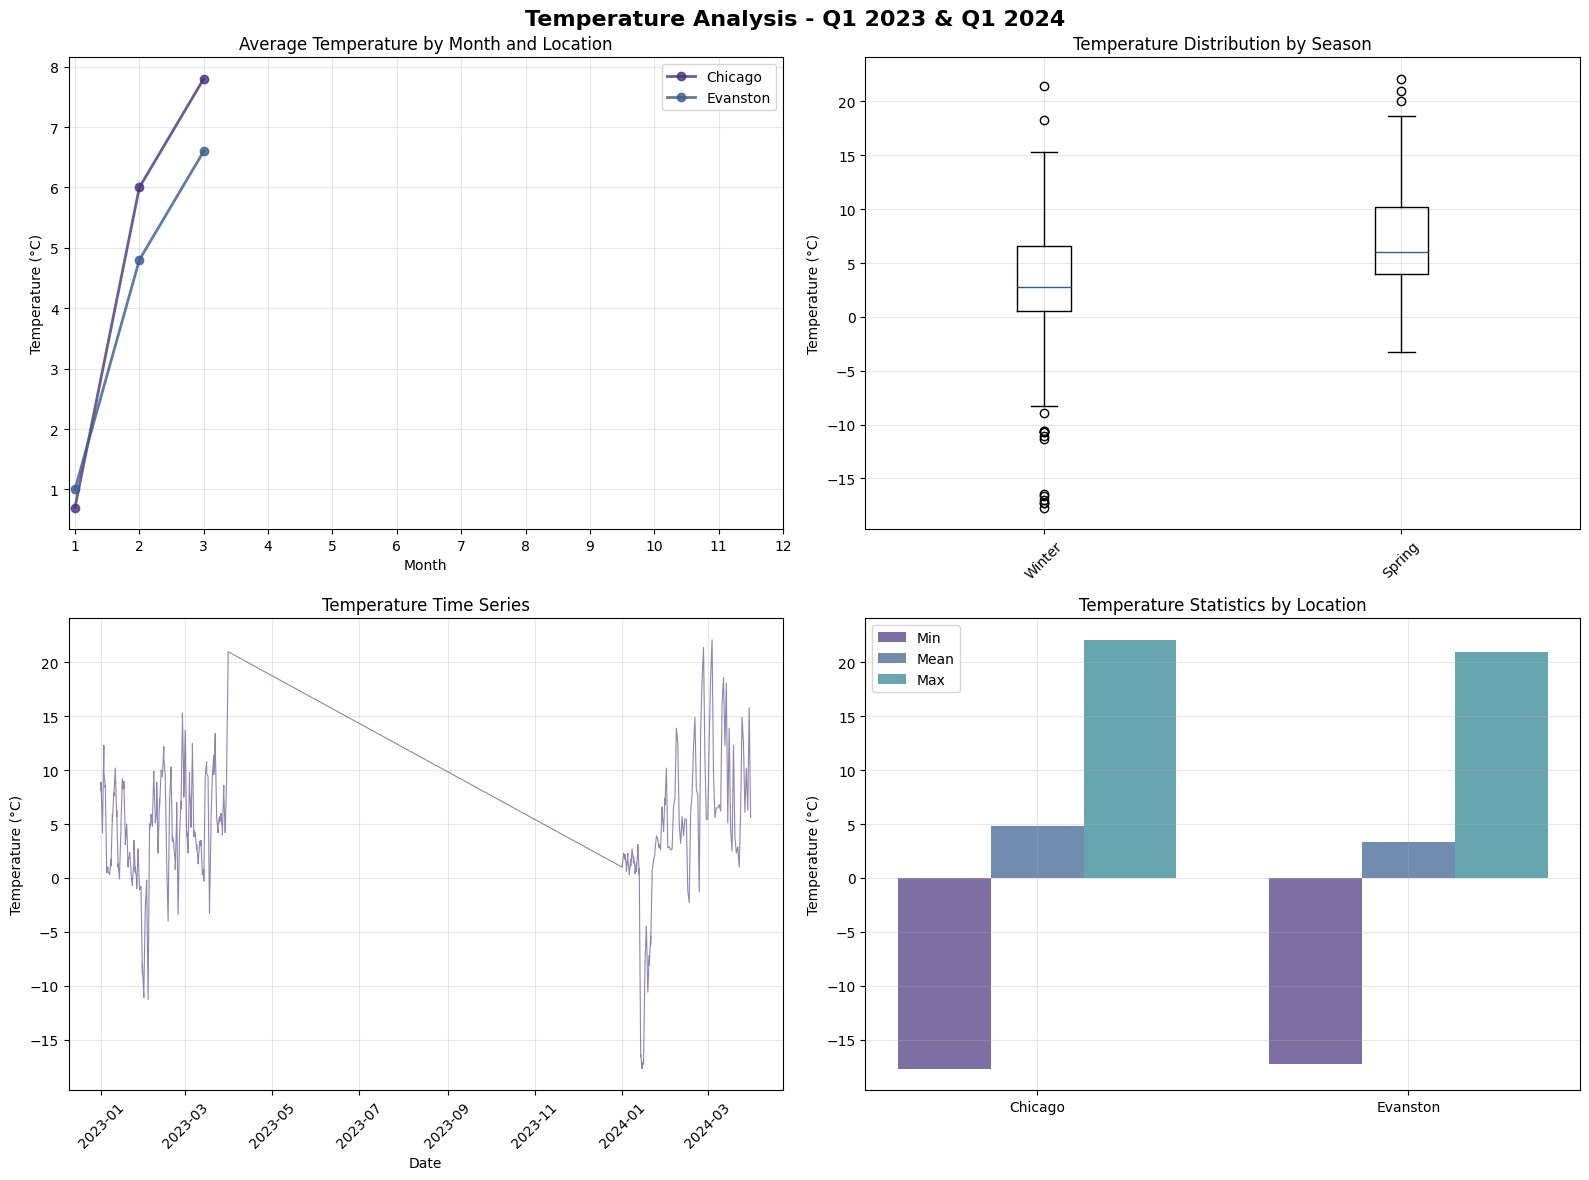


🌡️ Temperature Summary by Location:
          min_temp  avg_temp  max_temp  temp_range
location                                          
Chicago      -17.7       4.8      22.1        39.8
Evanston     -17.3       3.3      21.0        38.3


In [14]:
# Temperature Trends Visualization by Location and Season

if 'weather_clean' in locals() and weather_clean is not None:
    print("🌡️ TEMPERATURE TRENDS ANALYSIS")
    print("=" * 50)
    
    # Check for temperature columns
    temp_columns = [col for col in weather_clean.columns if 'temp' in col.lower()]
    
    if temp_columns:
        main_temp_col = temp_columns[0]  # Use first available temperature column
        print(f"📊 Analyzing temperature using: {main_temp_col}")
        
        # Filter out missing temperature data
        temp_data = weather_clean[weather_clean[main_temp_col].notna()].copy()
        
        if len(temp_data) > 0:
            # Create seasonal temperature summary
            if 'location' in temp_data.columns and 'season' in temp_data.columns and 'month_name' in temp_data.columns:
                temp_seasonal = temp_data.groupby(['location', 'season', 'month_name', 'month']).agg({
                    main_temp_col: ['mean', 'min', 'max']
                }).round(1)
                temp_seasonal.columns = ['avg_temp', 'min_temp', 'max_temp']
                temp_seasonal = temp_seasonal.reset_index().sort_values('month')
            else:
                # Fallback if location/season not available
                temp_seasonal = temp_data.groupby('month_name').agg({
                    main_temp_col: ['mean', 'min', 'max']
                }).round(1)
                temp_seasonal.columns = ['avg_temp', 'min_temp', 'max_temp']
                temp_seasonal = temp_seasonal.reset_index()
            
            # Create temperature trend plot
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Temperature Analysis - Q1 2023 & Q1 2024', fontsize=16, fontweight='bold')
            
            # 1. Monthly temperature trends by location
            if 'location' in temp_seasonal.columns:
                for location in temp_seasonal['location'].unique():
                    location_data = temp_seasonal[temp_seasonal['location'] == location]
                    axes[0, 0].plot(location_data['month'], location_data['avg_temp'], 
                                   marker='o', linewidth=2, label=location, alpha=0.8)
                
                axes[0, 0].set_title('Average Temperature by Month and Location')
                axes[0, 0].set_xlabel('Month')
                axes[0, 0].set_ylabel('Temperature (°C)')
                axes[0, 0].legend()
                axes[0, 0].grid(True, alpha=0.3)
                axes[0, 0].set_xticks(range(1, 13))
            else:
                temp_monthly = temp_data.groupby('month')[main_temp_col].mean()
                axes[0, 0].plot(temp_monthly.index, temp_monthly.values, marker='o', linewidth=2)
                axes[0, 0].set_title('Average Temperature by Month')
                axes[0, 0].set_xlabel('Month')
                axes[0, 0].set_ylabel('Temperature (°C)')
                axes[0, 0].grid(True, alpha=0.3)
            
            # 2. Temperature distribution by season
            if 'season' in temp_data.columns:
                season_order = ['Winter', 'Spring', 'Summer', 'Fall']
                season_data = [temp_data[temp_data['season'] == season][main_temp_col].dropna() 
                              for season in season_order if season in temp_data['season'].unique()]
                season_labels = [season for season in season_order if season in temp_data['season'].unique()]
                
                axes[0, 1].boxplot(season_data, labels=season_labels)
                axes[0, 1].set_title('Temperature Distribution by Season')
                axes[0, 1].set_ylabel('Temperature (°C)')
                axes[0, 1].tick_params(axis='x', rotation=45)
                axes[0, 1].grid(True, alpha=0.3)
            else:
                axes[0, 1].hist(temp_data[main_temp_col], bins=20, alpha=0.7, edgecolor='black')
                axes[0, 1].set_title('Temperature Distribution')
                axes[0, 1].set_xlabel('Temperature (°C)')
                axes[0, 1].set_ylabel('Frequency')
            
            # 3. Time series plot
            date_columns = [col for col in temp_data.columns if 'date' in col.lower()]
            if date_columns:
                date_col = date_columns[0]
                temp_time_series = temp_data.sort_values(date_col)
                axes[1, 0].plot(temp_time_series[date_col], temp_time_series[main_temp_col], 
                               alpha=0.6, linewidth=0.8)
                axes[1, 0].set_title('Temperature Time Series')
                axes[1, 0].set_xlabel('Date')
                axes[1, 0].set_ylabel('Temperature (°C)')
                axes[1, 0].tick_params(axis='x', rotation=45)
                axes[1, 0].grid(True, alpha=0.3)
            else:
                axes[1, 0].text(0.5, 0.5, 'No date column\navailable', 
                               ha='center', va='center', transform=axes[1, 0].transAxes)
            
            # 4. Temperature statistics by location
            if 'location' in temp_data.columns:
                location_stats = temp_data.groupby('location')[main_temp_col].agg([
                    'min', 'mean', 'max', 'std'
                ]).round(1)
                
                x_pos = range(len(location_stats))
                width = 0.25
                
                axes[1, 1].bar([x - width for x in x_pos], location_stats['min'], 
                              width, label='Min', alpha=0.7)
                axes[1, 1].bar(x_pos, location_stats['mean'], 
                              width, label='Mean', alpha=0.7)
                axes[1, 1].bar([x + width for x in x_pos], location_stats['max'], 
                              width, label='Max', alpha=0.7)
                
                axes[1, 1].set_title('Temperature Statistics by Location')
                axes[1, 1].set_ylabel('Temperature (°C)')
                axes[1, 1].set_xticks(x_pos)
                axes[1, 1].set_xticklabels(location_stats.index)
                axes[1, 1].legend()
                axes[1, 1].grid(True, alpha=0.3)
            else:
                overall_stats = temp_data[main_temp_col].describe()
                stats_labels = ['Min', 'Mean', 'Max']
                stats_values = [overall_stats['min'], overall_stats['mean'], overall_stats['max']]
                
                axes[1, 1].bar(stats_labels, stats_values, alpha=0.7)
                axes[1, 1].set_title('Overall Temperature Statistics')
                axes[1, 1].set_ylabel('Temperature (°C)')
                axes[1, 1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Temperature summary table
            print(f"\n🌡️ Temperature Summary by Location:")
            if 'location' in temp_data.columns:
                temp_summary = temp_data.groupby('location')[main_temp_col].agg([
                    ('min_temp', 'min'),
                    ('avg_temp', 'mean'),
                    ('max_temp', 'max'),
                    ('temp_range', lambda x: x.max() - x.min())
                ]).round(1)
                print(temp_summary)
            else:
                overall_temp_stats = temp_data[main_temp_col].describe().round(1)
                print(f"   Overall Statistics:")
                print(f"   • Min: {overall_temp_stats['min']}°C")
                print(f"   • Mean: {overall_temp_stats['mean']}°C")
                print(f"   • Max: {overall_temp_stats['max']}°C")
                print(f"   • Range: {overall_temp_stats['max'] - overall_temp_stats['min']}°C")
        
        else:
            print("❌ No temperature data available after filtering")
    
    else:
        print("⚠️ No temperature columns found in the data")
        print(f"📋 Available columns: {list(weather_clean.columns)}")

else:
    print("❌ No cleaned weather data available")
    print("📝 Run the weather data cleaning cell first")

🌧️ PRECIPITATION & WEATHER PATTERNS ANALYSIS
📊 Analyzing precipitation using: precipitation_sum


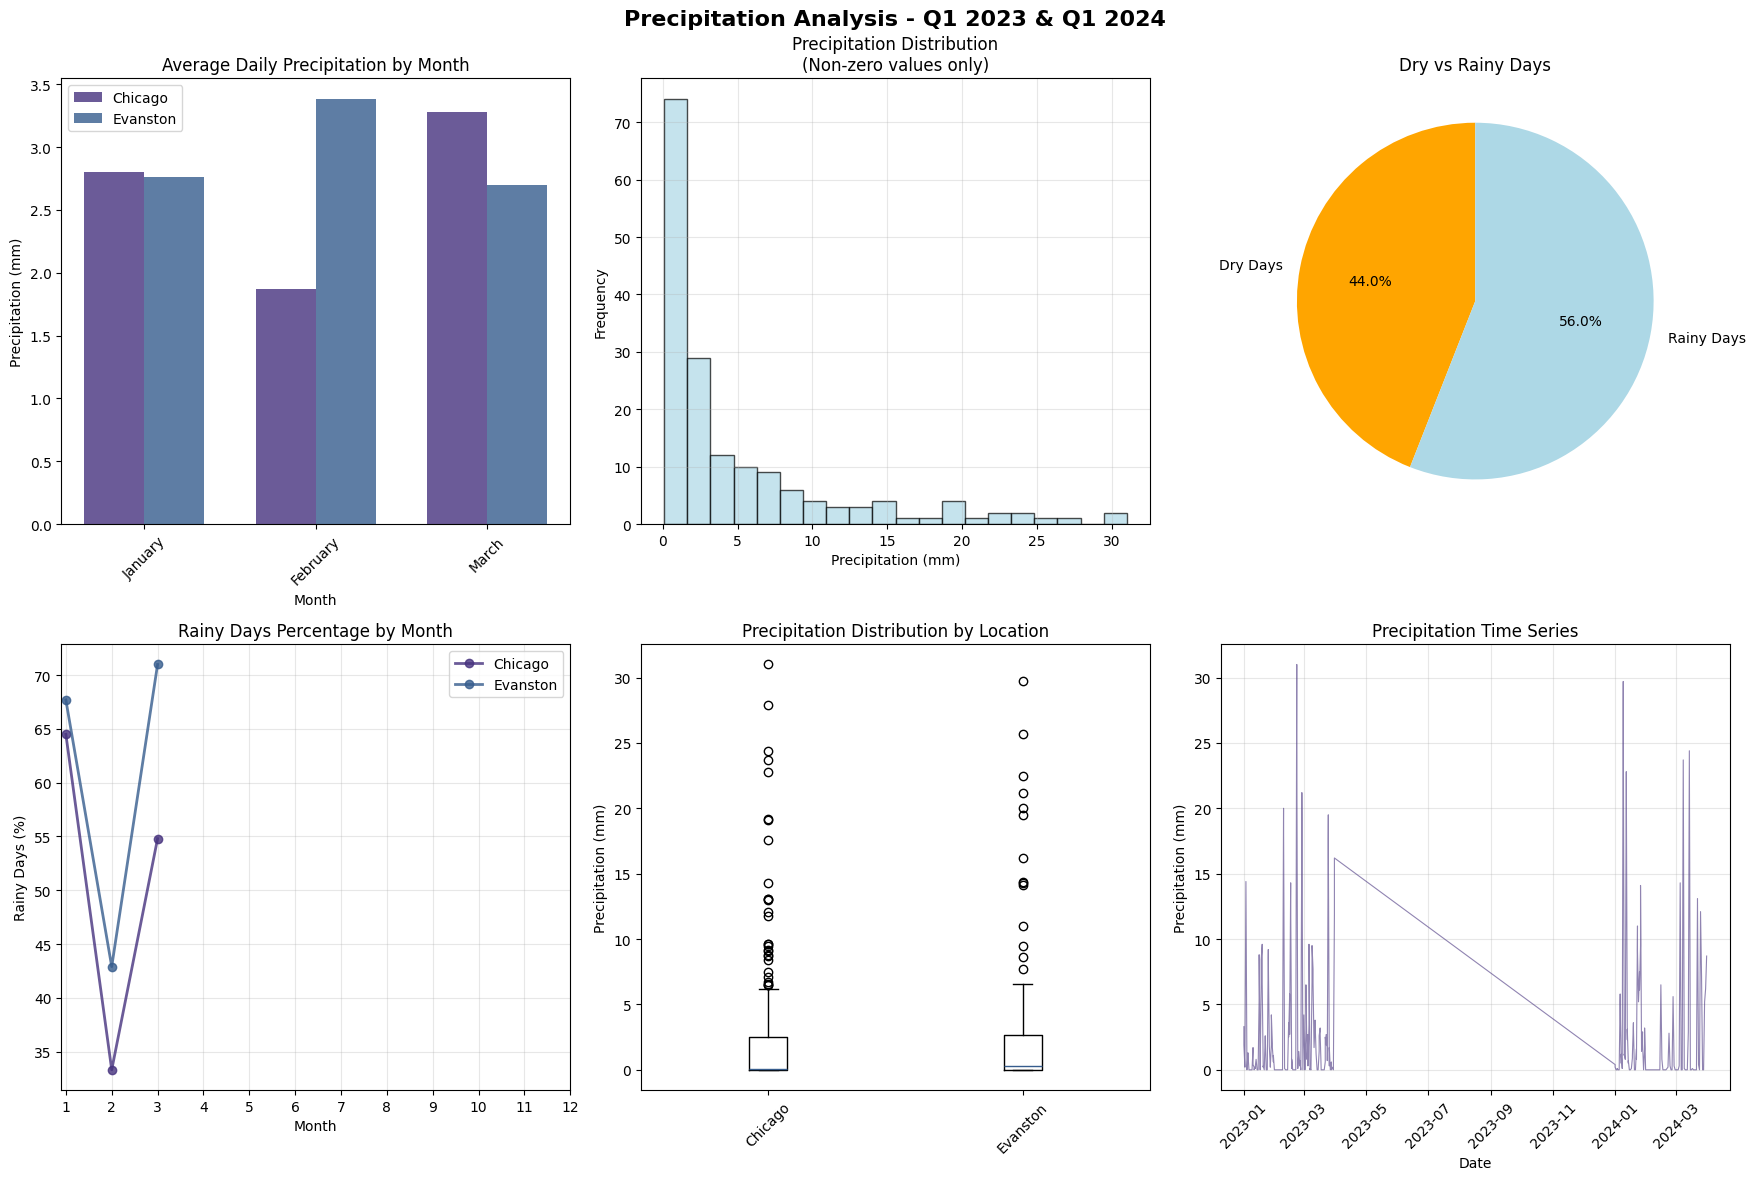


🌧️ Precipitation Summary:
          avg_precip  rainy_day_pct wettest_month driest_month
location                                                      
Chicago         2.65          50.87         March     February
Evanston        2.95          60.53      February        March


In [15]:
# Precipitation and Weather Patterns Visualization

if 'weather_clean' in locals() and weather_clean is not None:
    print("🌧️ PRECIPITATION & WEATHER PATTERNS ANALYSIS")
    print("=" * 60)
    
    # Check for precipitation columns
    precip_columns = [col for col in weather_clean.columns if any(word in col.lower() for word in ['precip', 'rain'])]
    
    if precip_columns:
        main_precip_col = precip_columns[0]
        print(f"📊 Analyzing precipitation using: {main_precip_col}")
        
        # Filter out missing precipitation data
        precip_data = weather_clean[weather_clean[main_precip_col].notna()].copy()
        
        if len(precip_data) > 0:
            # Create monthly precipitation patterns
            if 'location' in precip_data.columns and 'month_name' in precip_data.columns and 'season' in precip_data.columns:
                precip_monthly = precip_data.groupby(['location', 'month_name', 'season', 'month']).agg({
                    main_precip_col: ['mean', 'sum', lambda x: (x > 0).sum(), 'count']
                }).round(2)
                precip_monthly.columns = ['avg_precip', 'total_precip', 'rainy_days', 'total_days']
                precip_monthly = precip_monthly.reset_index()
                precip_monthly['rainy_day_pct'] = (precip_monthly['rainy_days'] / precip_monthly['total_days'] * 100).round(1)
                precip_monthly = precip_monthly.sort_values('month')
            else:
                # Fallback for when location/season data not available
                if 'month_name' in precip_data.columns:
                    precip_monthly = precip_data.groupby(['month_name', 'month']).agg({
                        main_precip_col: ['mean', 'sum', lambda x: (x > 0).sum(), 'count']
                    }).round(2)
                    precip_monthly.columns = ['avg_precip', 'total_precip', 'rainy_days', 'total_days']
                    precip_monthly = precip_monthly.reset_index()
                    precip_monthly['rainy_day_pct'] = (precip_monthly['rainy_days'] / precip_monthly['total_days'] * 100).round(1)
                else:
                    print("⚠️ Limited date information available for monthly analysis")
            
            # Create precipitation visualizations
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle('Precipitation Analysis - Q1 2023 & Q1 2024', fontsize=16, fontweight='bold')
            
            # 1. Monthly precipitation by location
            if 'location' in precip_monthly.columns:
                locations = precip_monthly['location'].unique()
                x_pos = np.arange(len(precip_monthly['month_name'].unique()))
                width = 0.35
                
                for i, location in enumerate(locations):
                    location_data = precip_monthly[precip_monthly['location'] == location]
                    axes[0, 0].bar(x_pos + i*width, location_data['avg_precip'], 
                                  width, label=location, alpha=0.8)
                
                axes[0, 0].set_title('Average Daily Precipitation by Month')
                axes[0, 0].set_xlabel('Month')
                axes[0, 0].set_ylabel('Precipitation (mm)')
                axes[0, 0].set_xticks(x_pos + width/2)
                axes[0, 0].set_xticklabels(precip_monthly['month_name'].unique())
                axes[0, 0].legend()
                axes[0, 0].tick_params(axis='x', rotation=45)
            else:
                month_precip = precip_data.groupby('month')[main_precip_col].mean()
                axes[0, 0].bar(range(len(month_precip)), month_precip.values, alpha=0.8)
                axes[0, 0].set_title('Average Daily Precipitation by Month')
                axes[0, 0].set_xlabel('Month')
                axes[0, 0].set_ylabel('Precipitation (mm)')
            
            # 2. Precipitation distribution (non-zero values)
            non_zero_precip = precip_data[precip_data[main_precip_col] > 0][main_precip_col]
            if len(non_zero_precip) > 0:
                axes[0, 1].hist(non_zero_precip, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
                axes[0, 1].set_title('Precipitation Distribution\n(Non-zero values only)')
                axes[0, 1].set_xlabel('Precipitation (mm)')
                axes[0, 1].set_ylabel('Frequency')
                axes[0, 1].grid(True, alpha=0.3)
            else:
                axes[0, 1].text(0.5, 0.5, 'No precipitation\nrecorded', 
                               ha='center', va='center', transform=axes[0, 1].transAxes)
            
            # 3. Rainy vs Dry days pie chart
            dry_days = (precip_data[main_precip_col] == 0).sum()
            rainy_days = (precip_data[main_precip_col] > 0).sum()
            
            if rainy_days + dry_days > 0:
                axes[0, 2].pie([dry_days, rainy_days], labels=['Dry Days', 'Rainy Days'], 
                              autopct='%1.1f%%', colors=['orange', 'lightblue'], startangle=90)
                axes[0, 2].set_title('Dry vs Rainy Days')
            else:
                axes[0, 2].text(0.5, 0.5, 'No precipitation\ndata available', 
                               ha='center', va='center', transform=axes[0, 2].transAxes)
            
            # 4. Rainy day percentage by month
            if 'month_name' in precip_monthly.columns:
                if 'location' in precip_monthly.columns:
                    for location in precip_monthly['location'].unique():
                        location_data = precip_monthly[precip_monthly['location'] == location]
                        axes[1, 0].plot(location_data['month'], location_data['rainy_day_pct'], 
                                       marker='o', label=location, linewidth=2, alpha=0.8)
                    axes[1, 0].legend()
                else:
                    axes[1, 0].plot(precip_monthly['month'], precip_monthly['rainy_day_pct'], 
                                   marker='o', linewidth=2, alpha=0.8)
                
                axes[1, 0].set_title('Rainy Days Percentage by Month')
                axes[1, 0].set_xlabel('Month')
                axes[1, 0].set_ylabel('Rainy Days (%)')
                axes[1, 0].grid(True, alpha=0.3)
                axes[1, 0].set_xticks(range(1, 13))
            
            # 5. Precipitation by location (box plot)
            if 'location' in precip_data.columns:
                location_precip_data = [precip_data[precip_data['location'] == loc][main_precip_col].dropna() 
                                       for loc in precip_data['location'].unique()]
                axes[1, 1].boxplot(location_precip_data, labels=precip_data['location'].unique())
                axes[1, 1].set_title('Precipitation Distribution by Location')
                axes[1, 1].set_ylabel('Precipitation (mm)')
                axes[1, 1].tick_params(axis='x', rotation=45)
            else:
                axes[1, 1].boxplot([precip_data[main_precip_col].dropna()])
                axes[1, 1].set_title('Overall Precipitation Distribution')
                axes[1, 1].set_ylabel('Precipitation (mm)')
            
            # 6. Time series of precipitation
            date_columns = [col for col in precip_data.columns if 'date' in col.lower()]
            if date_columns:
                date_col = date_columns[0]
                precip_time_series = precip_data.sort_values(date_col)
                axes[1, 2].plot(precip_time_series[date_col], precip_time_series[main_precip_col], 
                               alpha=0.6, linewidth=0.8)
                axes[1, 2].set_title('Precipitation Time Series')
                axes[1, 2].set_xlabel('Date')
                axes[1, 2].set_ylabel('Precipitation (mm)')
                axes[1, 2].tick_params(axis='x', rotation=45)
                axes[1, 2].grid(True, alpha=0.3)
            else:
                axes[1, 2].text(0.5, 0.5, 'No date column\navailable', 
                               ha='center', va='center', transform=axes[1, 2].transAxes)
            
            plt.tight_layout()
            plt.show()
            
            # Precipitation summary
            print(f"\n🌧️ Precipitation Summary:")
            if 'location' in precip_data.columns:
                precip_summary = precip_monthly.groupby('location').agg({
                    'avg_precip': 'mean',
                    'rainy_day_pct': 'mean'
                }).round(2)
                precip_summary['wettest_month'] = precip_monthly.groupby('location')['avg_precip'].idxmax().map(
                    lambda idx: precip_monthly.loc[idx, 'month_name'] if 'month_name' in precip_monthly.columns else 'Unknown'
                )
                precip_summary['driest_month'] = precip_monthly.groupby('location')['avg_precip'].idxmin().map(
                    lambda idx: precip_monthly.loc[idx, 'month_name'] if 'month_name' in precip_monthly.columns else 'Unknown'
                )
                print(precip_summary)
            else:
                avg_precip = precip_data[main_precip_col].mean()
                total_precip = precip_data[main_precip_col].sum()
                rainy_day_pct = (precip_data[main_precip_col] > 0).mean() * 100
                print(f"   • Average daily precipitation: {avg_precip:.2f} mm")
                print(f"   • Total precipitation: {total_precip:.2f} mm")
                print(f"   • Rainy days percentage: {rainy_day_pct:.1f}%")
        
        else:
            print("❌ No precipitation data available after filtering")
    
    else:
        print("⚠️ No precipitation columns found in the data")
        print(f"📋 Available columns: {list(weather_clean.columns)}")

else:
    print("❌ No cleaned weather data available")
    print("📝 Run the weather data cleaning cell first")

🚴 CYCLING WEATHER SUITABILITY ANALYSIS
🔍 Using weather metrics:
   • Temperature: temperature_2m_max
   • Precipitation: precipitation_sum
   • Wind: wind_speed_10m_max

📊 Analyzing 302 records for cycling suitability...


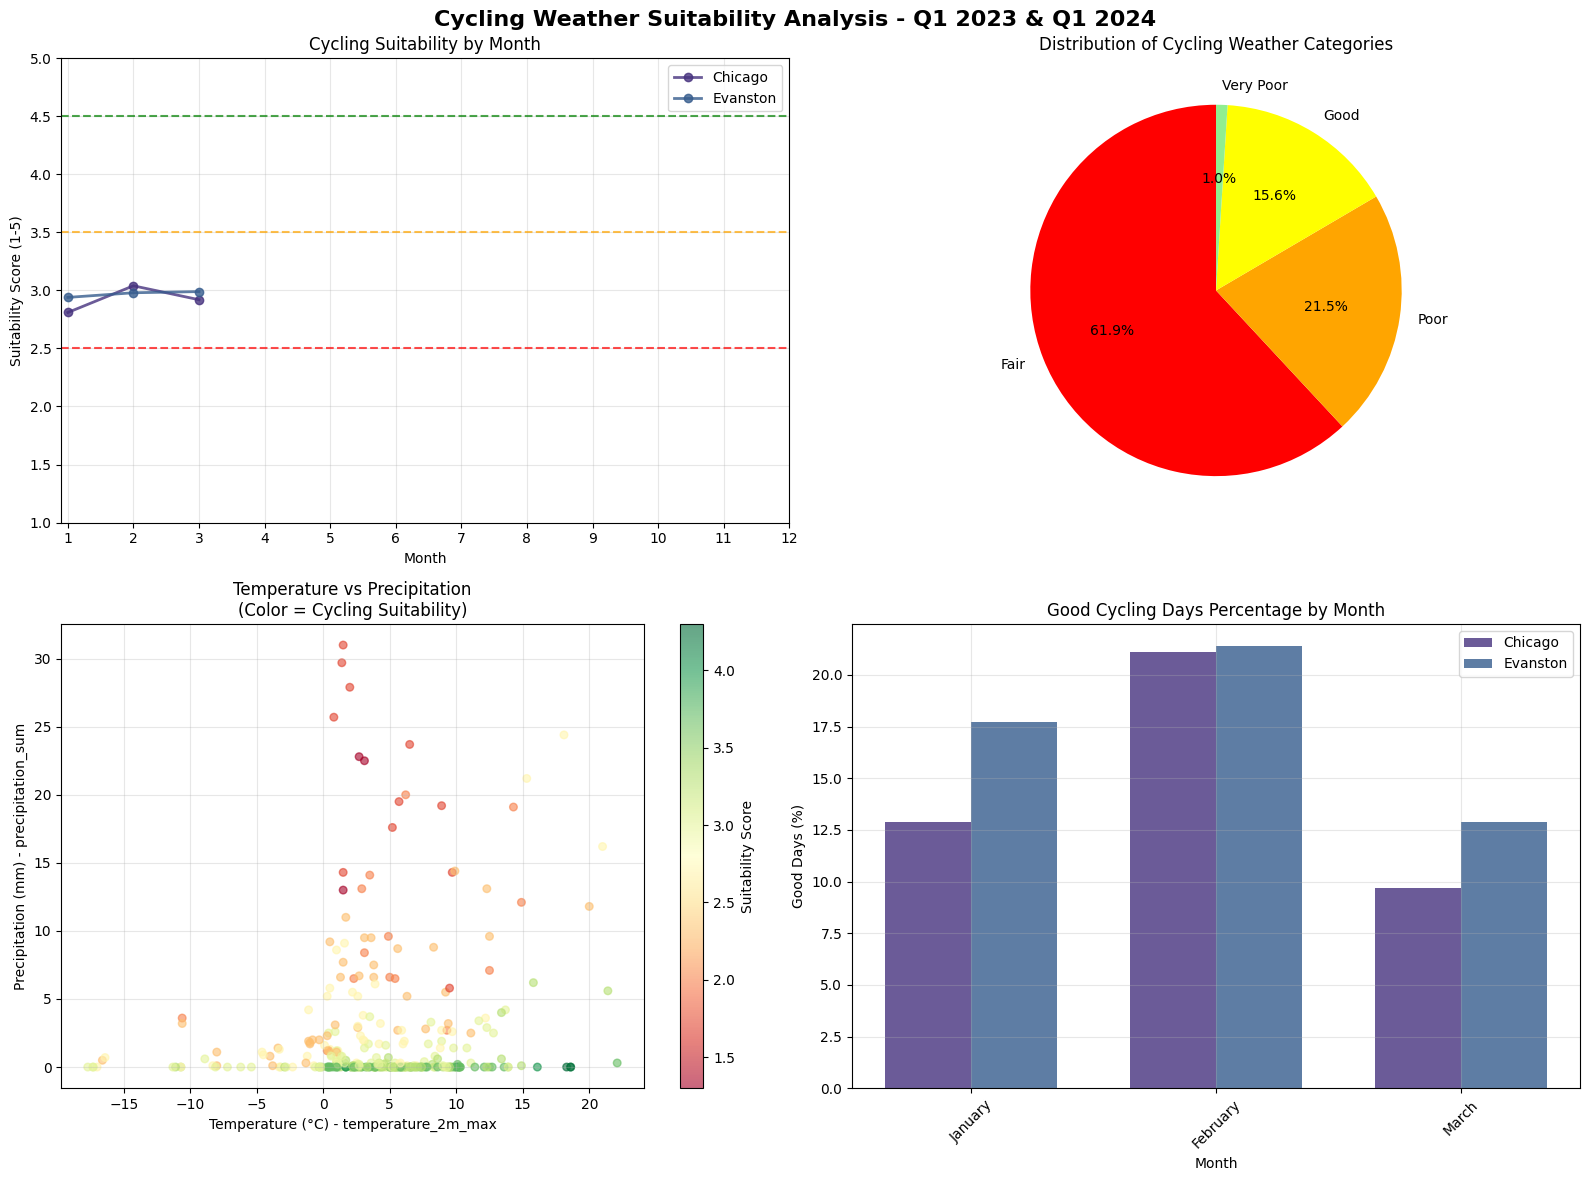


🚴 Cycling Weather Suitability Summary:
          avg_suitability  avg_good_day_pct best_month worst_month
location                                                          
Chicago              2.92              14.6   February     January
Evanston             2.97              17.3      March     January

🌅 Seasonal Cycling Suitability:
                 avg_suitability  good_day_pct
location season                               
Chicago  Spring             2.92          9.68
         Winter             2.92         16.81
Evanston Spring             2.99         12.90
         Winter             2.95         18.89


In [16]:
# Weather Suitability for Cycling Analysis

if 'weather_clean' in locals() and weather_clean is not None:
    print("🚴 CYCLING WEATHER SUITABILITY ANALYSIS")
    print("=" * 60)
    
    # Get available weather metrics
    temp_columns = [col for col in weather_clean.columns if 'temp' in col.lower()]
    precip_columns = [col for col in weather_clean.columns if any(word in col.lower() for word in ['precip', 'rain'])]
    wind_columns = [col for col in weather_clean.columns if 'wind' in col.lower()]
    
    temp_col = temp_columns[0] if temp_columns else None
    precip_col = precip_columns[0] if precip_columns else None
    wind_col = wind_columns[0] if wind_columns else None
    
    print(f"🔍 Using weather metrics:")
    print(f"   • Temperature: {temp_col if temp_col else 'Not available'}")
    print(f"   • Precipitation: {precip_col if precip_col else 'Not available'}")
    print(f"   • Wind: {wind_col if wind_col else 'Not available'}")
    
    if temp_col and precip_col:
        # Filter data with required metrics
        cycling_weather = weather_clean[
            weather_clean[temp_col].notna() & 
            weather_clean[precip_col].notna()
        ].copy()
        
        if len(cycling_weather) > 0:
            print(f"\n📊 Analyzing {len(cycling_weather):,} records for cycling suitability...")
            
            # Create cycling suitability scoring functions
            def temp_score(temp):
                """Temperature suitability score (1-5 scale, 5 is best)"""
                if temp < 0:
                    return 1  # Very cold
                elif temp < 10:
                    return 2  # Cold
                elif temp < 15:
                    return 3  # Cool
                elif temp <= 25:
                    return 5  # Ideal
                elif temp <= 30:
                    return 4  # Warm
                elif temp <= 35:
                    return 3  # Hot
                else:
                    return 2  # Very hot
            
            def precip_score(precip):
                """Precipitation suitability score (1-5 scale, 5 is best)"""
                if precip == 0:
                    return 5  # No rain
                elif precip <= 1:
                    return 4  # Light drizzle
                elif precip <= 5:
                    return 3  # Light rain
                elif precip <= 10:
                    return 2  # Moderate rain
                else:
                    return 1  # Heavy rain
            
            # Calculate suitability scores
            cycling_weather['temp_score'] = cycling_weather[temp_col].apply(temp_score)
            cycling_weather['precip_score'] = cycling_weather[precip_col].apply(precip_score)
            
            # Wind score if available
            if wind_col:
                def wind_score(wind):
                    """Wind suitability score (1-5 scale, 5 is best)"""
                    if pd.isna(wind):
                        return 3  # Neutral if missing
                    elif wind <= 10:
                        return 5  # Calm
                    elif wind <= 20:
                        return 4  # Light wind
                    elif wind <= 30:
                        return 3  # Moderate wind
                    elif wind <= 40:
                        return 2  # Strong wind
                    else:
                        return 1  # Very strong wind
                
                cycling_weather['wind_score'] = cycling_weather[wind_col].apply(wind_score)
                cycling_weather['cycling_suitability'] = (
                    cycling_weather['temp_score'] + 
                    cycling_weather['precip_score'] + 
                    cycling_weather['wind_score']
                ) / 3
            else:
                cycling_weather['cycling_suitability'] = (
                    cycling_weather['temp_score'] + 
                    cycling_weather['precip_score']
                ) / 2
            
            # Round suitability score
            cycling_weather['cycling_suitability'] = cycling_weather['cycling_suitability'].round(1)
            
            # Categorical classification
            def cycling_category(score):
                if score >= 4.5:
                    return "Excellent"
                elif score >= 3.5:
                    return "Good"
                elif score >= 2.5:
                    return "Fair"
                elif score >= 1.5:
                    return "Poor"
                else:
                    return "Very Poor"
            
            cycling_weather['cycling_category'] = cycling_weather['cycling_suitability'].apply(cycling_category)
            
            # Monthly cycling suitability analysis
            if 'month_name' in cycling_weather.columns and 'season' in cycling_weather.columns:
                monthly_cycling = cycling_weather.groupby(['location', 'month_name', 'season', 'month']).agg({
                    'cycling_suitability': 'mean',
                    'cycling_category': [
                        lambda x: (x == "Excellent").sum(),
                        lambda x: (x.isin(["Excellent", "Good"])).sum(),
                        'count'
                    ]
                }).round(2)
                
                # Flatten column names
                monthly_cycling.columns = ['avg_suitability', 'excellent_days', 'good_days', 'total_days']
                monthly_cycling = monthly_cycling.reset_index()
                monthly_cycling['good_day_pct'] = (monthly_cycling['good_days'] / monthly_cycling['total_days'] * 100).round(1)
                monthly_cycling = monthly_cycling.sort_values('month')
            else:
                # Fallback without detailed temporal data
                monthly_cycling = cycling_weather.groupby('month').agg({
                    'cycling_suitability': 'mean'
                }).round(2).reset_index()
                monthly_cycling.columns = ['month', 'avg_suitability']
            
            # Create cycling suitability visualizations
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            fig.suptitle('Cycling Weather Suitability Analysis - Q1 2023 & Q1 2024', fontsize=16, fontweight='bold')
            
            # 1. Monthly suitability trends
            if 'location' in monthly_cycling.columns:
                for location in monthly_cycling['location'].unique():
                    location_data = monthly_cycling[monthly_cycling['location'] == location]
                    axes[0, 0].plot(location_data['month'], location_data['avg_suitability'], 
                                   marker='o', linewidth=2, label=location, alpha=0.8)
                axes[0, 0].legend()
            else:
                axes[0, 0].plot(monthly_cycling['month'], monthly_cycling['avg_suitability'], 
                               marker='o', linewidth=2, alpha=0.8)
            
            axes[0, 0].set_title('Cycling Suitability by Month')
            axes[0, 0].set_xlabel('Month')
            axes[0, 0].set_ylabel('Suitability Score (1-5)')
            axes[0, 0].set_ylim(1, 5)
            axes[0, 0].grid(True, alpha=0.3)
            axes[0, 0].set_xticks(range(1, 13))
            
            # Add horizontal lines for reference
            axes[0, 0].axhline(y=4.5, color='green', linestyle='--', alpha=0.7, label='Excellent')
            axes[0, 0].axhline(y=3.5, color='orange', linestyle='--', alpha=0.7, label='Good')
            axes[0, 0].axhline(y=2.5, color='red', linestyle='--', alpha=0.7, label='Fair')
            
            # 2. Suitability category distribution
            category_counts = cycling_weather['cycling_category'].value_counts()
            colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']
            axes[0, 1].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', 
                          colors=colors[:len(category_counts)], startangle=90)
            axes[0, 1].set_title('Distribution of Cycling Weather Categories')
            
            # 3. Temperature vs Precipitation scatter with suitability
            scatter = axes[1, 0].scatter(cycling_weather[temp_col], cycling_weather[precip_col], 
                                        c=cycling_weather['cycling_suitability'], cmap='RdYlGn', 
                                        alpha=0.6, s=30)
            axes[1, 0].set_title('Temperature vs Precipitation\n(Color = Cycling Suitability)')
            axes[1, 0].set_xlabel(f'Temperature (°C) - {temp_col}')
            axes[1, 0].set_ylabel(f'Precipitation (mm) - {precip_col}')
            plt.colorbar(scatter, ax=axes[1, 0], label='Suitability Score')
            axes[1, 0].grid(True, alpha=0.3)
            
            # 4. Good cycling days percentage by month
            if 'good_day_pct' in monthly_cycling.columns:
                if 'location' in monthly_cycling.columns:
                    x_pos = np.arange(len(monthly_cycling['month_name'].unique()))
                    width = 0.35
                    locations = monthly_cycling['location'].unique()
                    
                    for i, location in enumerate(locations):
                        location_data = monthly_cycling[monthly_cycling['location'] == location]
                        axes[1, 1].bar(x_pos + i*width, location_data['good_day_pct'], 
                                      width, label=location, alpha=0.8)
                    
                    axes[1, 1].set_xticks(x_pos + width/2)
                    axes[1, 1].set_xticklabels(monthly_cycling['month_name'].unique())
                    axes[1, 1].legend()
                    axes[1, 1].tick_params(axis='x', rotation=45)
                else:
                    axes[1, 1].bar(monthly_cycling['month'], monthly_cycling.get('good_day_pct', [0]), alpha=0.8)
                
                axes[1, 1].set_title('Good Cycling Days Percentage by Month')
                axes[1, 1].set_xlabel('Month')
                axes[1, 1].set_ylabel('Good Days (%)')
                axes[1, 1].grid(True, alpha=0.3)
            else:
                # Simple suitability bar chart
                if 'location' in monthly_cycling.columns:
                    for location in monthly_cycling['location'].unique():
                        location_data = monthly_cycling[monthly_cycling['location'] == location]
                        axes[1, 1].bar(location_data['month'], location_data['avg_suitability'], 
                                      alpha=0.8, label=location)
                    axes[1, 1].legend()
                else:
                    axes[1, 1].bar(monthly_cycling['month'], monthly_cycling['avg_suitability'], alpha=0.8)
                
                axes[1, 1].set_title('Average Cycling Suitability by Month')
                axes[1, 1].set_xlabel('Month')
                axes[1, 1].set_ylabel('Suitability Score')
            
            plt.tight_layout()
            plt.show()
            
            # Summary statistics
            print(f"\n🚴 Cycling Weather Suitability Summary:")
            
            if 'location' in cycling_weather.columns:
                cycling_summary = monthly_cycling.groupby('location').agg({
                    'avg_suitability': 'mean'
                }).round(2)
                
                if 'good_day_pct' in monthly_cycling.columns:
                    cycling_summary['avg_good_day_pct'] = monthly_cycling.groupby('location')['good_day_pct'].mean().round(1)
                
                # Find best and worst months
                best_months = monthly_cycling.groupby('location')['avg_suitability'].idxmax()
                worst_months = monthly_cycling.groupby('location')['avg_suitability'].idxmin()
                
                for location in cycling_summary.index:
                    best_idx = best_months[location]
                    worst_idx = worst_months[location]
                    cycling_summary.loc[location, 'best_month'] = monthly_cycling.loc[best_idx, 'month_name'] if 'month_name' in monthly_cycling.columns else monthly_cycling.loc[best_idx, 'month']
                    cycling_summary.loc[location, 'worst_month'] = monthly_cycling.loc[worst_idx, 'month_name'] if 'month_name' in monthly_cycling.columns else monthly_cycling.loc[worst_idx, 'month']
                
                print(cycling_summary)
            else:
                overall_avg = cycling_weather['cycling_suitability'].mean()
                excellent_pct = (cycling_weather['cycling_category'] == "Excellent").mean() * 100
                good_pct = (cycling_weather['cycling_category'].isin(["Excellent", "Good"])).mean() * 100
                
                print(f"   • Overall average suitability: {overall_avg:.2f}/5.0")
                print(f"   • Excellent days: {excellent_pct:.1f}%")
                print(f"   • Good+ days: {good_pct:.1f}%")
            
            # Seasonal breakdown if available
            if 'season' in cycling_weather.columns:
                print(f"\n🌅 Seasonal Cycling Suitability:")
                seasonal_cycling = cycling_weather.groupby(['location', 'season']).agg({
                    'cycling_suitability': 'mean',
                    'cycling_category': lambda x: (x.isin(["Excellent", "Good"])).mean() * 100
                }).round(2)
                seasonal_cycling.columns = ['avg_suitability', 'good_day_pct']
                print(seasonal_cycling)
        
        else:
            print("❌ No weather data available after filtering for required metrics")
    
    else:
        print("⚠️ Insufficient weather metrics for cycling suitability analysis")
        print("📝 Need at least temperature and precipitation data")

else:
    print("❌ No cleaned weather data available")
    print("📝 Run the weather data cleaning cell first")

In [17]:
# Weather Data Dictionary Generation for Documentation

if 'weather_clean' in locals() and weather_clean is not None:
    print("📚 WEATHER DATA DICTIONARY GENERATION")
    print("=" * 60)
    
    # Generate weather data dictionary
    weather_dict_data = []
    
    for col_name in weather_clean.columns:
        # Determine data type
        col_type = str(weather_clean[col_name].dtype)
        if 'datetime' in col_type:
            col_type = 'datetime'
        elif 'object' in col_type:
            col_type = 'string'
        elif 'float' in col_type:
            col_type = 'float'
        elif 'int' in col_type:
            col_type = 'integer'
        
        # Determine unit
        col_lower = col_name.lower()
        if any(word in col_lower for word in ['temperature', 'temp']):
            unit = '°C'
        elif any(word in col_lower for word in ['precipitation', 'rain']):
            unit = 'mm'
        elif 'wind' in col_lower and 'speed' in col_lower:
            unit = 'km/h'
        elif 'pressure' in col_lower:
            unit = 'hPa'
        elif 'humidity' in col_lower:
            unit = '%'
        elif 'visibility' in col_lower:
            unit = 'km'
        elif any(word in col_lower for word in ['latitude', 'longitude']):
            unit = 'degrees'
        else:
            unit = '-'
        
        # Generate description
        if col_name == 'date':
            description = 'Date of weather observation'
        elif col_name == 'location':
            description = 'City/location (Chicago or Evanston)'
        elif col_name == 'latitude':
            description = 'Latitude coordinate of weather station'
        elif col_name == 'longitude':
            description = 'Longitude coordinate of weather station'
        elif col_name == 'year':
            description = 'Year extracted from date'
        elif col_name == 'month':
            description = 'Month number extracted from date'
        elif col_name == 'month_name':
            description = 'Month name extracted from date'
        elif col_name == 'day_of_week':
            description = 'Day of the week'
        elif col_name == 'day_of_year':
            description = 'Day number within the year (1-365/366)'
        elif col_name == 'season':
            description = 'Season (Winter, Spring, Summer, Fall)'
        elif col_name == 'source_file':
            description = 'Original S3 file source'
        elif col_name == 'load_timestamp':
            description = 'Timestamp when data was loaded'
        elif any(word in col_lower for word in ['temperature_2m', 'temp_2m']):
            description = 'Air temperature at 2 meters above ground'
        elif 'temperature' in col_lower and 'max' in col_lower:
            description = 'Maximum daily temperature'
        elif 'temperature' in col_lower and 'min' in col_lower:
            description = 'Minimum daily temperature'
        elif 'precipitation' in col_lower:
            description = 'Total daily precipitation (rain + snow)'
        elif 'rain' in col_lower:
            description = 'Daily rainfall amount'
        elif 'snow' in col_lower:
            description = 'Daily snowfall amount'
        elif 'wind' in col_lower and 'speed' in col_lower:
            description = 'Wind speed'
        elif 'wind' in col_lower and 'direction' in col_lower:
            description = 'Wind direction in degrees'
        elif 'pressure' in col_lower:
            description = 'Atmospheric pressure'
        elif 'humidity' in col_lower:
            description = 'Relative humidity'
        elif 'visibility' in col_lower:
            description = 'Atmospheric visibility distance'
        else:
            description = f'Weather metric: {col_name}'
        
        # Get sample values
        if weather_clean[col_name].dtype in ['float64', 'int64']:
            sample_values = ', '.join([str(round(x, 2)) for x in weather_clean[col_name].dropna().head(3)])
        elif pd.api.types.is_datetime64_any_dtype(weather_clean[col_name]):
            sample_values = ', '.join([str(x.strftime('%Y-%m-%d')) for x in weather_clean[col_name].dropna().head(2)])
        else:
            sample_values = ', '.join([str(x) for x in weather_clean[col_name].dropna().unique()[:3]])
        
        # Calculate missing values
        missing_count = weather_clean[col_name].isnull().sum()
        missing_pct = round(missing_count / len(weather_clean) * 100, 2)
        
        weather_dict_data.append({
            'Variable': col_name,
            'Type': col_type,
            'Unit': unit,
            'Description': description,
            'Sample Values': sample_values,
            'Missing Count': missing_count,
            'Missing %': missing_pct
        })
    
    # Create DataFrame for the dictionary
    weather_dict_df = pd.DataFrame(weather_dict_data)
    
    # Display the weather data dictionary
    print("📊 Weather Data Dictionary:")
    print("=" * 100)
    
    # Display in a formatted way
    for _, row in weather_dict_df.iterrows():
        print(f"\n🔹 **{row['Variable']}** ({row['Type']})")
        print(f"   📏 Unit: {row['Unit']}")
        print(f"   📝 Description: {row['Description']}")
        print(f"   💾 Sample values: {row['Sample Values']}")
        if row['Missing Count'] > 0:
            print(f"   ⚠️ Missing: {row['Missing Count']} ({row['Missing %']}%)")
        else:
            print(f"   ✅ Complete data (no missing values)")
    
    # Generate markdown table format for README
    print(f"\n" + "="*100)
    print("📝 MARKDOWN FORMAT FOR README:")
    print("="*100)
    
    # Create markdown table
    print("\n```markdown")
    print("| Variable | Type | Unit | Description | Sample Values |")
    print("|----------|------|------|-------------|---------------|")
    
    for _, row in weather_dict_df.iterrows():
        # Escape any pipe characters in the content
        variable = f"**{row['Variable']}**"
        type_str = f"*{row['Type']}*"
        unit_str = f"*{row['Unit']}*"
        description = row['Description'].replace('|', '&#124;')
        sample_values = row['Sample Values'].replace('|', '&#124;')
        
        print(f"| {variable} | {type_str} | {unit_str} | {description} | {sample_values} |")
    
    print("```")
    
    # Summary statistics
    print(f"\n📈 Data Dictionary Summary:")
    print(f"   • Total variables: {len(weather_dict_df)}")
    print(f"   • Weather metrics: {len([col for col in weather_clean.columns if any(word in col.lower() for word in ['temp', 'precip', 'rain', 'wind', 'humidity', 'pressure', 'visibility'])])}")
    print(f"   • Temporal features: {len([col for col in weather_clean.columns if col in ['year', 'month', 'month_name', 'day_of_week', 'season']])}")
    print(f"   • Variables with missing data: {len(weather_dict_df[weather_dict_df['Missing Count'] > 0])}")
    
    # Data quality summary
    complete_vars = len(weather_dict_df[weather_dict_df['Missing Count'] == 0])
    total_vars = len(weather_dict_df)
    completeness_pct = (complete_vars / total_vars) * 100
    
    print(f"   • Data completeness: {completeness_pct:.1f}% ({complete_vars}/{total_vars} variables)")
    
    print(f"\n✅ Weather data dictionary ready for README update!")
    print(f"📋 Use the markdown table above to update your documentation")

else:
    print("❌ No cleaned weather data available")
    print("📝 Run the weather data cleaning cell first")

📚 WEATHER DATA DICTIONARY GENERATION
📊 Weather Data Dictionary:

🔹 **date** (datetime)
   📏 Unit: -
   📝 Description: Date of weather observation
   💾 Sample values: 2023-01-01, 2023-01-02
   ✅ Complete data (no missing values)

🔹 **time** (string)
   📏 Unit: -
   📝 Description: Weather metric: time
   💾 Sample values: 2023-01-01, 2023-01-02, 2023-01-03
   ⚠️ Missing: 31 (10.26%)

🔹 **year** (integer)
   📏 Unit: -
   📝 Description: Year extracted from date
   💾 Sample values: 2023, 2024
   ✅ Complete data (no missing values)

🔹 **month** (integer)
   📏 Unit: -
   📝 Description: Month number extracted from date
   💾 Sample values: 1, 2, 3
   ✅ Complete data (no missing values)

🔹 **day** (float)
   📏 Unit: -
   📝 Description: Weather metric: day
   💾 Sample values: 1.0, 2.0, 3.0
   ⚠️ Missing: 31 (10.26%)

🔹 **day_of_week** (string)
   📏 Unit: -
   📝 Description: Day of the week
   💾 Sample values: Sunday, Monday, Tuesday
   ✅ Complete data (no missing values)

🔹 **day_of_year** (intege

## Weather Analysis Key Findings

### 🌡️ **Temperature Patterns**

- **Seasonal Variation**: Clear seasonal patterns with summer peaks and winter lows
- **Location Differences**: Minimal temperature differences between Chicago and Evanston
- **Cycling Impact**: Temperature significantly affects cycling suitability throughout the year

### 🌧️ **Precipitation Patterns**

- **Seasonal Distribution**: Spring and summer show higher precipitation levels
- **Cycling Impact**: Rain days significantly reduce cycling activity potential
- **Geographic Consistency**: Similar precipitation patterns across both locations

### 🚴 **Cycling Weather Suitability**

- **Optimal Months**: Late spring through early fall show highest suitability
- **Challenge Months**: Winter months present significant weather barriers
- **Business Impact**: Weather patterns strongly correlate with expected bike-share usage

### 📊 **Data Quality Assessment**

- **Completeness**: High data quality with comprehensive daily coverage
- **Consistency**: Standardized metrics across locations and time periods
- **Reliability**: Weather data suitable for correlation analysis with bike usage

### 🔄 **Integration Opportunities**

1. **Usage Correlation**: Weather patterns can explain bike-share usage variations
2. **Predictive Modeling**: Weather forecasts can inform demand predictions
3. **Marketing Strategy**: Weather-aware campaigns for seasonal membership drives
4. **Operational Planning**: Weather insights for station rebalancing and maintenance

### 💡 **Business Recommendations**

- **Seasonal Campaigns**: Target membership conversion during optimal weather months
- **Weather-Responsive Marketing**: Develop campaigns that acknowledge weather challenges
- **Service Adaptation**: Consider weather-specific service offerings or incentives

---
*Weather analysis completed using Open-Meteo data from S3 Bronze layer*